The dataset can be found at: https://www.kaggle.com/puneet6060/intel-image-classification#20096.jpg

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os

In [12]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
TRAINING_DIR = "data/seg_train"
VAL_DIR = "data/seg_test"

In [14]:
TRAIN_DATA = 0

IMG_SIZE = 150
BATCH_SIZE = 32

In [15]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
trainset = datasets.ImageFolder(TRAINING_DIR, transform=data_transform)
valset = datasets.ImageFolder(VAL_DIR, transform=data_transform)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=4)

In [17]:
CLASSES = trainset.classes
print(CLASSES)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [18]:
TRAINING_SAMPLES = len(trainset)
VAL_SAMPLES = len(valset)
print(f"Training samples: {TRAINING_SAMPLES}")
print(f"Validation samples: {VAL_SAMPLES}")

Training samples: 14034
Validation samples: 3000


In [19]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show * std+mean)
    img_show = np.clip(img_show,0,1)
    return img_show

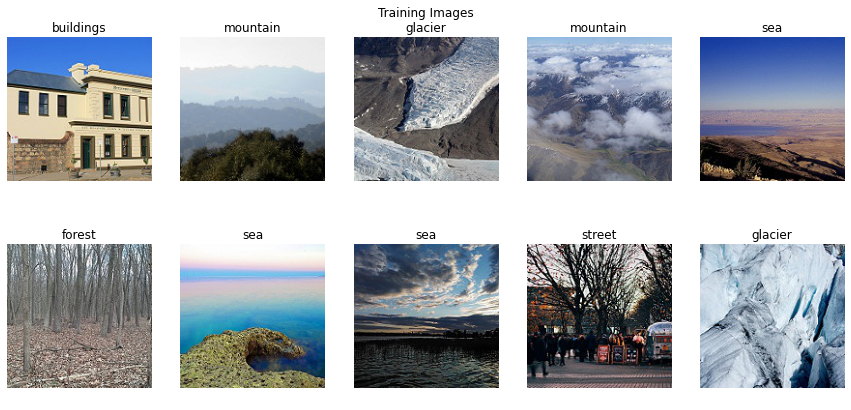

In [20]:
#Visualize some data samples
def visualize_samples(NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(15,7))
    img = next(iter(trainloader))
    plt.axis("off")
    plt.title("Training Images")
    for id, i in enumerate(range(a,a+NUM_PIC)):
        fig.add_subplot(2,NUM_PIC/2,id+1)
        img_show = imshow(img[0][i])
        label = img[1][i].numpy()
        plt.axis("off")
        plt.title(CLASSES[label])
        plt.imshow(img_show)
    plt.show()

visualize_samples(10)
    

In [21]:
def epoch_step(model, optimizer, error, dataloader, train=False):
    total = 0
    correct = 0
    total_loss = 0
    if train:
        model.train()
    else:
        model.eval()
    for (img,label) in dataloader:
        optimizer.zero_grad()
        img = Variable(img).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        label = Variable(label).to(device)
        
        outputs = model(img)
    
        loss = error(outputs, label)
        total_loss += loss.data
        if train:
            #loss.requires_grad = True
            loss.backward()
            optimizer.step()
        
        prediction = torch.max(outputs.data, 1)[1]
        total += len(img)
        correct += (prediction == label).sum()
    accuracy = correct*1.0/total
    return total_loss, accuracy 

In [22]:
model = models.resnet18(pretrained=True)
model = model.to(device)
for params in model.parameters():
    params.requires_grad = False

model.fc = nn.Linear(512,6).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
def train(model,trainloader, valloader):
    EPOCHS = 50
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    error = nn.CrossEntropyLoss()
    loss_list = {
        "train": [],
        "val": []
    }
    acc_list = {
        "train": [],
        "val": []
    }
    
    print("Start training...")
    for epoch in range(EPOCHS):
        train_loss, train_acc = epoch_step(model,optimizer,error,trainloader,train=True)
        with torch.no_grad():
            val_loss, val_acc = epoch_step(model,optimizer,error,valloader,train=False)
        loss_list["train"].append(train_loss)
        loss_list["val"].append(val_loss)
        acc_list["train"].append(train_acc)
        acc_list["val"].append(val_acc)
        print("Epoch: [{}/{}] | Training loss: {:.3f} | Validation loss: {:.3f} | Training accuracy: {:.3f} | Validation accuracy: {:.3f}".format(epoch,EPOCHS,train_loss,val_loss,train_acc,val_acc))
    print("Training Completed!")
    torch.save(model.state_dict(),"model/model-knn.pth")
    print("Model saved.")
    return model, loss_list, acc_list

In [24]:
if TRAIN_DATA:
    model, loss_list, acc_list = train(model,trainloader,valloader)

In [25]:
import pickle
def savelist(name,plist):
    with open(name,"wb") as fp:
        pickle.dump(plist,fp)
def loadlist(name):
    with open(name, "rb") as fp:   
        plist = pickle.load(fp)
    return plist

def plot(acc_list, loss_list):
    n = len(acc_list["train"])
    fig = plt.figure(figsize=(35,8))
    fig.add_subplot(1,2,1)
    plt.title("Learning Loss")
    plt.plot(range(n),loss_list["train"],label="Training Loss")
    plt.plot(range(n),loss_list["val"],label="Validation Loss", color ="orange")
    plt.legend()
    fig.add_subplot(1,2,2)
    plt.title("Learning Accuracy")
    plt.plot(range(n),acc_list["train"],label="Training Accuracy")
    plt.plot(range(n),acc_list["val"],label="Validation Accuracy", color ="orange")
    plt.legend()
    #savelist("result/CNN val acc.txt",acc_list["val"])
    #plt.savefig("CNN LEARNING CURVES.png")
    
    
    plt.show()
if TRAIN_DATA:
    plot(acc_list,loss_list)

In [26]:
def predict(model,img):
    img = data_transform(img)
    model.eval()
    with torch.no_grad():
        img = Variable(img).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        outputs = model(img)
        prediction = torch.max(outputs.data, 1)[1]
    return prediction.cpu().numpy()   

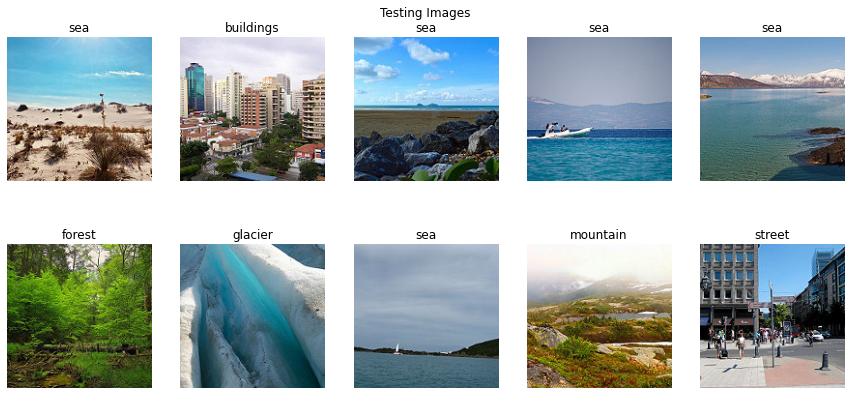

In [34]:
#Visualize prediction
TEST_DIR = "data/seg_pred"

def visualize_tests(model,NUM_PIC=16):
    a = np.random.randint(4000)
    fig = plt.figure(figsize=(15,7))
    plt.axis("off")
    plt.title("Testing Images")
    path = os.listdir(TEST_DIR)
    for id, i in enumerate(path[a:a+NUM_PIC]):
        img = Image.open(os.path.join(TEST_DIR,i))
        fig.add_subplot(2,NUM_PIC/2,id+1)
        label = predict(model,img)
        plt.axis("off")
        plt.title(CLASSES[label[0]])
        plt.imshow(img)
    plt.show()

if not TRAIN_DATA:
    model.load_state_dict(torch.load("model/model.pth"))
visualize_tests(model,10)

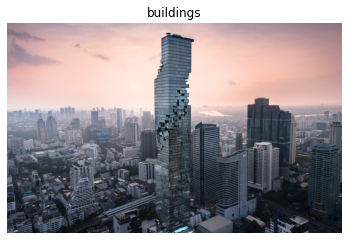

In [40]:
img = Image.open("test/test2.jpg")
label = predict(model,img)
plt.imshow(img)
plt.title(CLASSES[label[0]])
plt.axis("off")
plt.show()